In [13]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import FiniteDiff
import ForwardDiff as FD
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
using MeshCat
const mc = MeshCat
using TrajOptPlots
using StaticArrays
using Printf

  Activating environment at `~/Desktop/courses/ocrl/OptimizationProj/Project.toml`


In [14]:
include(joinpath(@__DIR__, "utils","ilc_visualizer.jl"))

vis_traj! (generic function with 1 method)

We will model the dynamics of the car as with a simple nonlinear bicycle model, with the following state and control:

$$\begin{align} x = \begin{bmatrix} p_x \\ p_y \\ \theta \\ \delta \\ v \\ \omega \end{bmatrix}, &\quad \quad u = \begin{bmatrix} a \\ \dot{\delta} \end{bmatrix}  \end{align} $$ 

where $p_x$ and $p_y$ describe the 2d position of the bike, $\theta$ is the orientation, $\delta$ is the steering angle, and $v$ is the velocity. The controls for the bike are acceleration $a$, and steering angle rate $\dot{\delta}$.  

In [15]:
function estimated_car_dynamics(model::NamedTuple, x::Vector, u::Vector)::Vector
    # nonlinear bicycle model continuous time dynamics 
    px, py, θ, δ, v = x 
    a, δdot = u 
    
    β = atan(model.lr * δ, model.L)
    s,c = sincos(θ + β)
    ω = v*cos(β)*tan(δ) / model.L
    
    vx = v*c 
    vy = v*s 
    
    xdot = [
        vx,
        vy,
        ω,
        δdot, 
        a
    ]
    
    return xdot 
end
function rk4(model::NamedTuple, ode::Function, x::Vector, u::Vector, dt::Real)::Vector
    k1 = dt * ode(model, x,        u)
    k2 = dt * ode(model, x + k1/2, u)
    k3 = dt * ode(model, x + k2/2, u)
    k4 = dt * ode(model, x + k3,   u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end   

rk4 (generic function with 1 method)

We have computed an optimal trajectory $X_{ref}$ and $U_{ref}$ for a moose test trajectory offline using this `estimated_car_dynamics` function. Unfortunately, this is a highly approximate dynamics model, and when we run $U_{ref}$ on the car, we get a very different trajectory than we expect. This is caused by a significant sim to real gap. Here we will show what happens when we run these controls on the true dynamics:

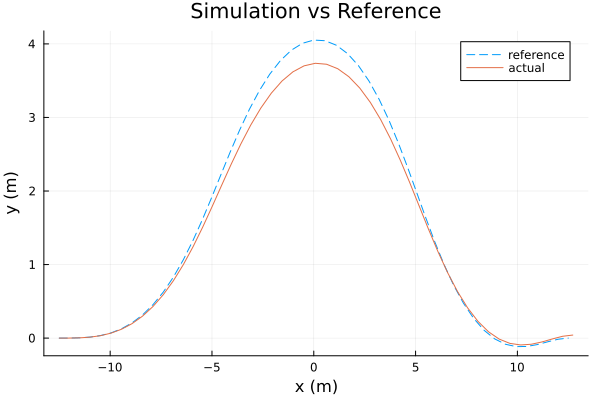

Test Summary:   |
sim to real gap | No tests


Test.DefaultTestSet("sim to real gap", Any[], 0, false, false)

In [115]:
function load_car_trajectory()
    # load in trajectory we computed offline 
    path = joinpath(@__DIR__, "utils","init_control_car_ilc.jld2")
    F = jldopen(path)
    Xref = F["X"]
    Uref = F["U"]
    close(F)
    return Xref, Uref
end

function load_threePoint_trajectory()
    # load in trajectory we computed offline 
    path = joinpath(@__DIR__, "utils","threePoint.jld2")
    F = jldopen(path)
    Xref = F["X"]
    Uref = F["U"]
    close(F)
    return Xref, Uref
end

function load_laneChange_trajectory()
    # load in trajectory we computed offline 
    path = joinpath(@__DIR__, "utils","laneChange.jld2")
    F = jldopen(path)
    Xref = F["X"]
    Uref = F["U"]
    close(F)
    return Xref, Uref
end

function true_car_dynamics(model::NamedTuple, x::Vector, u::Vector)::Vector
    # true car dynamics 
    px, py, θ, δ, v = x 
    a, δdot = u 
    
    # sluggish controls (not in the approximate version)
    # a = 0.9*a - 0.1 
    # δdot = 0.9*δdot - .1*δ + .1

    a = 0.95*a
    δdot = 0.95*δdot 
    
    β = atan(model.lr * δ, model.L)
    s,c = sincos(θ + β)
    ω = v*cos(β)*tan(δ) / model.L
    
    vx = v*c 
    vy = v*s 
    
    xdot = [
        vx,
        vy,
        ω,
        δdot, 
        a
    ]
    
    return xdot 
end

@testset "sim to real gap" begin 
    # problem size 
    nx = 5
    nu = 2
    dt = 0.1
    tf = 5
    # dt = 0.2
    # tf = 20
    t_vec = 0:dt:tf 
    N = length(t_vec)
    model = (L = 2.8, lr = 1.6)
    
    # optimal trajectory computed offline with approximate model 
    Xref, Uref = load_car_trajectory()
    # Xref, Uref = load_laneChange_trajectory()
    # Xref, Uref = load_threePoint_trajectory()
    
    # simulated Uref with the true car dynamics and store the states in Xsim
    Xsim = [zeros(nx) for i = 1:N]
    Xsim[1] = Xref[1]
    P = ones(2,5) * 0.0
    D = ones(2,5) * 0.0
    # lambda 
    # P = [0.010481131706307743 -0.0030915306441409236 -0.0009862214786092944 0.0002198371613356281 -0.017604427762517836; 0.004725541684936217 6.652525928870458e-5 -0.006206162909406199 -6.924154033456236e-13 -0.009803608579136432]
    # D = [0.00713526445252735 -0.01576713291000989 0.1574734758581987 -1.6504958494918202e-12 0.010301421130436883; 0.0026928103626889777 -0.015526779900929677 0.051460971758547046 -0.032337476592359124 0.0032555765408289307]
    # P = [0.002265935746017142 -0.008041199085570966 0.00236184798820644 4.111578485311185e-5 0.001627299581157231; -8.551744343902357e-5 -0.0047126311042761035 -0.017766249721232242 -0.050483766808534385 0.0018343509900285667]
    # D = [0.006806438324434826 -0.06740388171444968 0.572701152491245 -0.23289025265023802 0.056190085966609564; 0.0010556428451500904 -0.02343150232557007 -0.01620987162301107 -0.11367427461575338 0.10634857488061372]
    # P = [-0.005682051578845005 0.0008338794855744979 0.013527648962045478 0.0770112052104465 -0.0016334849143720101; -0.0013978031550630143 0.0019802665061840587 -0.007065381566089569 0.054641846472420576 -0.0060135089742755264]
    # D = [-0.012343627645771314 0.02522358387167284 0.3305305966524146 -0.674073062161211 0.25250756145758924; -0.003658096943639403 0.07509889509376039 -0.21182461190763832 0.26030150066036856 -0.1525126817289646]
    # P = [-0.004316435374390559 0.0017237691627789151 0.009994308341729501 0.06339964512334036 -0.0015543649030932015; -0.0013856284204010274 0.0015798133311378897 -0.006054808506689523 0.04400601244776754 -0.005186365231112667]
    # D = [-0.009493479350086747 5.547050093848758e-7 0.23644312469675643 -0.5965317610810769 0.20352878988561765; -0.0035061217029100393 0.06665877602616203 -0.1895512478491912 0.2155969433944781 -0.12978306715518112]
    # P = [-0.004476395766220842 0.0016239733103552828 0.010460209602075577 0.06521951687900854 -0.0015331115416343933; -0.001413842787738435 0.0017186210515401621 -0.0061481295689959905 0.045645574942195025 -0.005320111147480036]
    # D = [-0.009811981765515024 3.6232849037934795e-5 0.24564527189948915 -0.6141550174243161 0.2102933954842788; -0.0036018479283451373 0.06796202853568181 -0.1936105638542927 0.2188374445640595 -0.1320870818038432]
    # P = [-0.0059092645117797 0.0006645431431102529 0.014187519443606286 0.07945975427665193 -0.0015987733374808854; -0.0014286685671071153 0.0021681857920897987 -0.007180002168349872 0.05691582759263833 -0.006185713457757277]
    # D = [-0.012793540347718575 0.025696821960959154 0.3439260203370997 -0.696272908773211 0.26180481311025805; -0.0037716712340375817 0.07669197365793402 -0.21680640434517726 0.26425508862787556 -0.15548459264866651]
    # P = [-0.005909184964767372 0.0006643667710686944 0.01418809061448408 0.0794560968598685 -0.0015983687634190307; -0.0014285590835590816 0.0021684811435202624 -0.007179894514731578 0.056921362308308035 -0.006185719506068114]
    # D = [-0.012793333988969832 0.025688821975896326 0.3439241279318418 -0.696264624137207 0.26180578378344754; -0.003771593634780874 0.07668739459965264 -0.21680014266672848 0.2642233602707337 -0.15547911725530947]
    # P = [-0.004458385626205902 0.0013328791971907946 0.010758947313339425 0.06092389588964183 -0.0012921979333675778; -0.0012565637459436218 0.001698455438303481 -0.006024256775634477 0.05254328289814522 -0.0052825170045729284]
    # D = [-0.009727301202993708 -1.4176148777552354e-10 0.24716683086103844 -0.5931791443742728 0.20799749098276923; -0.003240783372339376 0.06401176913959776 -0.18092728734458705 0.20043304743262472 -0.12898661038677833]
    P = [0.002051860467329642 -0.007886867874662943 -4.224434469318824e-11 1.0876554012351047e-6 0.0012360957814705356; 0.0001806665922960199 -0.0032596313239906106 -0.010642680721080135 -0.02711039094239578 0.0011041276208030306]
    D = [0.006306879133670008 -0.06668556840929239 0.5432685805761701 -0.21283570704482477 0.05578200106175858; 0.0012911738764295197 -0.01928984414260765 3.677881688685214e-11 -0.1064127693652638 0.06617964702248677]
        

    Xlast = Xref[1]
    for i = 1:N-1
        u_next = Uref[i] - P * (Xref[i] - Xsim[i]) - D * (Xsim[i] - Xlast)
        Xsim[i+1] = rk4(model, true_car_dynamics, Xsim[i], u_next, dt)
        Xlast = Xsim[i]
    end

    
    # --------plotting/animation-------
    Xm= hcat(Xsim...)
    Xrefm = hcat(Xref...)
    plot(Xrefm[1,:], Xrefm[2,:], ls = :dash, label = "reference",
         xlabel = "x (m)", ylabel = "y (m)", title = "Simulation vs Reference")
    display(plot!(Xm[1,:], Xm[2,:], label = "actual"))
    
end

### Optimal PID

To encourage the trajectory of the bike to follow the reference, the objective value for this problem is the following:
$$  J(X) = \sum_{i=1}^{N-1} \bigg[ \frac{1}{2} (x_i - x_{ref,i})^TQ(x_i - x_{ref,i})]$$

We are to linearize our approximate dynamics model about $X_{ref}$ and $U_{ref}$ to get the following Jacobians:

$$ A_k = \frac{\partial f}{\partial x}\bigg|_{x_{ref,k},u_{ref,k}}, \quad \quad B_k = \frac{\partial f}{\partial u}\bigg|_{x_{ref,k},u_{ref,k}} $$

where $f(x,u)$ is our **approximate discrete** dynamics model (`estimated_car_dynamics` + `rk4`). **You will form these Jacobians exactly once, using `Xref` and `Uref`.**  Here is a summary of the notation:

- $X_{ref}$ (`Xref`) -  Optimal trajectory computed offline with approximate dynamics model. 
- $U_{ref}$ (`Uref`) -  Optimal controls computed offline with approximate dynamics model. 
- $X_{sim}$ (`Xsim`) -  Simulated trajectory with real dynamics model.


In the second step of ILC, we solve the following optimization problem:

   $$ \begin{align} \min_{\Delta x_{1:N}} \quad & J(X_{sim} + \Delta X)\\ 
 \text{st} \quad & \Delta x_1 = 0 \\ 
 & \Delta x_{k+1} = A_k \Delta x_k - P (X_{sim_k} - X_{ref_k}) - D (X_{sim_k} - X_{sim_{k-1}}) \text{ for } k = 2,3,\ldots,N-1  \\
 \end{align}$$
 

Here we will run the optimization for determining the P,D gain matrices given ideal and approximate dynamics. 

The resulting plots should show the simulated trajectory `Xsim` tracks `Xref` very closely, but there should be a significant difference between `Uref` and `Ubar`.

In [83]:

function trajectory_cost(Xsim::Vector{Vector{Float64}}, # simulated states 
    Ubar::Vector{Vector{Float64}}, # simulated controls (ILC iterates this)
    Xref::Vector{Vector{Float64}}, # reference X's we want to track
    Uref::Vector{Vector{Float64}}, # reference U's we want to track 
    Q::Matrix,                     # LQR tracking cost term 
    R::Matrix,                     # LQR tracking cost term
    Qf::Matrix,                     # LQR tracking cost term
    N1,
    N2
)::Float64                     # return cost J 

    J = 0
    N = length(Xsim)

    for i = 1:N-1
        xdiff = Xsim[i] - Xref[i]
        cost= (Xsim[i] - Xref[i])' * Q * (Xsim[i] - Xref[i])
        # println("Cost:", i, " ", cost)

        J += cost

    end

    return J
end

function vec_from_mat(Xm::Matrix)::Vector{Vector{Float64}}
    # convert a matrix into a vector of vectors 
    X = [Xm[:, i] for i = 1:size(Xm, 2)]
    return X
end

# Optimization loop for determining P,D gains 
function optim_pd(Xsim::Vector{Vector{Float64}}, # simulated states 
    Ubar::Vector{Vector{Float64}}, # simulated controls (ILC iterates this)
    Xref::Vector{Vector{Float64}}, # reference X's we want to track
    Uref::Vector{Vector{Float64}}, # reference U's we want to track 
    As::Vector{Matrix{Float64}},   # vector of A jacobians at each time step 
    Bs::Vector{Matrix{Float64}},   # vector of B jacobians at each time step 
    Q::Matrix,                     # LQR tracking cost term 
    R::Matrix,                     # LQR tracking cost term
    Qf::Matrix,                     # LQR tracking cost term
    N1,
    N2
) 
    # Solve optimization problem for ILC update
    N = length(Xsim)
    nx, nu = size(Bs[1])

    # Create variables 
    ΔX = cvx.Variable(nx, N)
    ΔU = cvx.Variable(nu, N - 1)
    P = cvx.Variable(2, 5)
    D = cvx.Variable(2, 5)

    # TODO: Make lambda an optimizable variable also
    lambda = 1
    # lambda = cvx.Variable(1)

    println("optim 1")
    # Cost function (tracking cost on Xref, Uref)
    # TODO: Try including I into the formulation
    cost = 0
    for i = 1:N-1
        xdiff = (Xsim[i] - Xref[i]) + ΔX[:, i]

        state_cost = cvx.quadform(xdiff, Q)

        # NOTE: Regularization needed because P,D being too big is bad for PD control
        # NOTE: L1 Regularization will tend to result in sparser P,D matrices
        # TODO: Try L2 Regularization?

        cost += state_cost
    end

    L_norm = 1
    norm_cost = lambda * (cvx.LinearAlgebra.norm(vec(P), L_norm) + cvx.LinearAlgebra.norm(vec(D), L_norm))
    cost += norm_cost


    println("optim 2")
    # Problem instance 
    prob = cvx.minimize(cost)

    # Initial condition constraint
    prob.constraints += ΔX[:, 1] == 0
    prob.constraints += ΔX[:, N1+1] == 0
    prob.constraints += ΔX[:, N1+N2+1] == 0
    println("optim 3")


    ######

    println("optim 5")
    # Dynamics constraints
    xlast = Xsim[1]
    for i = 1:N1-1
        ΔU[:, i] == -P * (Xref[i] - Xsim[i]) - D * (Xsim[i] - xlast)
        prob.constraints += ΔX[:, i+1] == As[i] * ΔX[:, i] + Bs[i] * (-P * (Xref[i] - Xsim[i]) - D * (Xsim[i] - xlast))
        xlast = Xsim[i]
    end

    println("optim 6")
    xlast = Xsim[N1]
    for i = N1:N2+N1-1
        ΔU[:, i-1] == -P * (Xref[i-N1+1] - Xsim[i]) - D * (Xsim[i] - xlast)
        prob.constraints += ΔX[:, i+1] == As[i-1] * ΔX[:, i] + Bs[i-1] * (-P * (Xref[i-N1+1] - Xsim[i]) - D * (Xsim[i] - xlast))
        xlast = Xsim[i]
    end
    println("optim 7")
    xlast = Xsim[N1 + N2]
    for i = N1+N2:N2+N1+N2-1
        ΔU[:, i-2] == -P * (Xref[i-N1-N2+1] - Xsim[i]) - D * (Xsim[i] - xlast)
        prob.constraints += ΔX[:, i+1] == As[i-2] * ΔX[:, i] + Bs[i-2] * (-P * (Xref[i-N1-N2+1] - Xsim[i]) - D * (Xsim[i] - xlast))
        xlast = Xsim[i]
    end

    # Lambda constraint
    # prob.constraints += lambda >= 0
    # prob.constraints += lambda < 1

    # run and solve
    cvx.solve!(prob, ECOS.Optimizer; silent_solver=true)

    P = P.value
    D = D.value
    println("P = ", P)
    println("D = ", D)

    return P, D
end

optim_pd (generic function with 2 methods)

In [109]:
@testset "Optimization for PD Gain Determination" begin

    # problem size 
    nx = 5
    nu = 2
    dt = 0.1
    dt2 = 0.2
    tf = 5.0
    t_vec = 0:dt:tf
    N = length(t_vec)

    # optimal trajectory computed offline with approximate model 
    Xref1, Uref1 = load_car_trajectory()
    Xref2, Uref2 = load_laneChange_trajectory()
    Xref3, Uref3 = load_threePoint_trajectory()

    # stack the trajectories
    Xref = vcat(Xref1, Xref2, Xref3)
    Uref = vcat(Uref1, Uref2, Uref3)
    println(size(Xref))
    println(size(Uref))

    N1 = length(Xref1)
    N2 = length(Xref2)
    N3 = length(Xref3)

    # initial and terminal conditions 
    xic1 = Xref[1]
    xg1 = Xref[N1]

    xic2 = Xref[N1+1]
    xg2 = Xref[N1+N2]

    xic3 = Xref[N1+N2+1]
    xg3 = Xref[N1+N2+N2]

    N = N1 + N2 + N3


    # LQR tracking cost to be used in ILC 
    Q = diagm([1, 1, 1, 0, 0.1])
    R = 0.1 * diagm(ones(nu)) * 0.1
    Qf = diagm([1000, 1000, 0, 0, 0])

    # load all useful things into params 
    model = (L=2.8, lr=1.6)

    params = (Q=Q, R=R, Qf=Qf, xic=xic2, xg=xg2, Xref=Xref, Uref=Uref,
        dt=dt,
        N=N,
        model=model)

    
    # this holds the sim trajectory (with real dynamics)
    Xsim = [zeros(nx) for i = 1:N]

    # this is the feedforward control ILC is updating 
    Ubar = [zeros(nu) for i = 1:(N-1)]

    # calculate Jacobians 
    As = [zeros(nx, nx) for i = 1:N-3]
    Bs = [zeros(nu, nu) for i = 1:N-3]


    @printf("Pre Calculating Jacobians... \n")
    println("Traj1")
    for i = 1:N1-1
        As[i] = FD.jacobian(dx -> rk4(model, estimated_car_dynamics, dx, Uref[i], dt), Xref[i])
        Bs[i] = FD.jacobian(du -> rk4(model, estimated_car_dynamics, Xref[i], du, dt), Uref[i])
    end

    println("Traj2")
    for i = N1-1:N1+N2-2
        As[i] = FD.jacobian(dx -> rk4(model, estimated_car_dynamics, dx, Uref[i], dt2), Xref[i+1])
        Bs[i] = FD.jacobian(du -> rk4(model, estimated_car_dynamics, Xref[i+1], du, dt2), Uref[i])
    end

    println("Traj3")
    for i = N1+N2-2:N1+N2+N2-3
        As[i] = FD.jacobian(dx -> rk4(model, estimated_car_dynamics, dx, Uref[i], dt2), Xref[i+2])
        Bs[i] = FD.jacobian(du -> rk4(model, estimated_car_dynamics, Xref[i+2], du, dt2), Uref[i])
    end

    println("Done generating A/B")
    # Initialize P, D to 0
    # TODO: test different initializations?
    # NOTE: Different initializations should not affect the solution because convex
    P = zeros(2, 5)
    D = zeros(2, 5)

    # logging stuff 
    @printf "iter     objv        |ΔU|     \n"
    @printf "------------------------------\n"

    # Move the robot (forward rollout)
    Xsim[1] = xic1
    Xlast = xic1
    for i = 1:N1-1
        u_next = Uref[i] - P * (Xref[i] - Xsim[i]) - D * (Xsim[i] - Xlast)
        Xsim[i+1] = rk4(model, true_car_dynamics, Xsim[i], u_next, dt)
        Xlast = Xsim[i]
    end

    Xsim[N1+1] = xic2
    Xlast = xic2
    for i = N1+1:N1+N2-1
        u_next = Uref[i-1] - P * (Xref[i] - Xsim[i]) - D * (Xsim[i] - Xlast)
        Xsim[i+1] = rk4(model, true_car_dynamics, Xsim[i], u_next, dt2)
        Xlast = Xsim[i]
    end

    Xsim[N1+N2+1] = xic3
    Xlast = xic3
    for i = N2+N1+1:N1+N2+N2-1
        u_next = Uref[i-2] - P * (Xref[i] - Xsim[i]) - D * (Xsim[i] - Xlast)
        Xsim[i+1] = rk4(model, true_car_dynamics, Xsim[i], u_next, dt2)
        Xlast = Xsim[i]
    end

    println("done rollout")

    # Calculate objective val (trajectory_cost) 
    obj_val = trajectory_cost(Xsim, Ubar, Xref, Uref, Q, R, Qf, N1, N2)

    # Logging
    @printf("Trajectory Cost: %10.3e\n", obj_val)

    println("laounching optim_pd")

    # Solve optimization problem for update (optim_pd)
    P, D = optim_pd(Xsim, Ubar, Xref, Uref, As, Bs, Q, R, Qf, N1, N2)


    # # Move the robot after final optimized values (final forward rollout)
    # Xsim[1] = xic
    # Xlast = xic
    # for i = 1:N-1
    #     u_next = Uref[i] - P * (Xref[i] - Xsim[i]) - D * (Xsim[i] - Xlast)
    #     Xsim[i+1] = rk4(model, true_car_dynamics, Xsim[i], u_next, dt)
    #     Xlast = Xsim[i]
    # end

    # # --------Plotting/animation-------
    # Xm = hcat(Xsim...)
    # Um = hcat(Ubar...)
    # Xrefm = hcat(Xref...)
    # Urefm = hcat(Uref...)
    # plot(Xrefm[1, :], Xrefm[2, :], ls=:dash, label="reference",
    #     xlabel="x (m)", ylabel="y (m)", title="Trajectory")
    # display(plot!(Xm[1, :], Xm[2, :], label="actual"))

    # plot(t_vec[1:end-1], Urefm', ls=:dash, lc=[:green :blue], label="",
    #     xlabel="time (s)", ylabel="controls", title="Controls (-- is reference)")
    # display(plot!(t_vec[1:end-1], Um', label=["δ̇" "a"], lc=[:green :blue]))

    # # Animation
    # vis = Visualizer()
    # X_vis = [[x[1], x[2], 0.1] for x in Xsim]
    # vis_traj!(vis, :traj, X_vis; R=0.02)
    # vis_model = TrajOptPlots.RobotZoo.BicycleModel()
    # TrajOptPlots.set_mesh!(vis, vis_model)
    # X = [x[SA[1, 2, 3, 4]] for x in Xsim]
    # visualize!(vis, vis_model, tf, X)
    # display(render(vis))
end
     

(253,)
(250,)


Pre Calculating Jacobians... 
Traj1
Traj2


Traj3


Done generating A/B


iter     objv        |ΔU|     
------------------------------
done rollout
Trajectory Cost:  7.592e+01
laounching optim_pd
optim 1
optim 2
optim 3
optim 5
optim 6
optim 7


P = [0.002051860467329642 -0.007886867874662943 -4.224434469318824e-11 1.0876554012351047e-6 0.0012360957814705356; 0.0001806665922960199 -0.0032596313239906106 -0.010642680721080135 -0.02711039094239578 0.0011041276208030306]
D = [0.006306879133670008 -0.06668556840929239 0.5432685805761701 -0.21283570704482477 0.05578200106175858; 0.0012911738764295197 -0.01928984414260765 3.677881688685214e-11 -0.1064127693652638 0.06617964702248677]
Test Summary:                          |
Optimization for PD Gain Determination | No tests


Test.DefaultTestSet("Optimization for PD Gain Determination", Any[], 0, false, false)